# Parametric Bootstrap for the One‑Sample Kolmogorov–Smirnov Test

This notebook implements the simulation study described in **Section 2** of  
*Zeimbekakis (2022) “On Misuses of the Kolmogorov–Smirnov Test for One‑Sample Goodness‑of‑Fit”*.

Two distributions are examined:

* **Gamma** $(k=2,\;\theta=1)$
* **Weibull** $(\alpha=1.5,\;\beta=1)$

Adjust the `SAMPLE_TRIALS`, `SAMPLE_SIZE`, and `BOOTSTRAP_B` constants to trade off runtime vs. accuracy.

In [37]:
# --- simulation settings ----------------------------------------------------
SAMPLE_TRIALS = 100    # replicate datasets
SAMPLE_SIZE   = 100    # sample size per dataset
BOOTSTRAP_B   = 100   # bootstrap resamples per replicate
RNG_SEED      = 2025

from scipy.stats import gamma, weibull_min, kstest
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal

rng = np.random.default_rng(RNG_SEED)
distribution = Literal['gamma', 'weibull']

Firstly, we implement the naive KS test, which uses the parameters fitted from the the data for the null distribution.

In [38]:
def ks_pvalue_naive(data, dist: distribution) -> float:
    """Mis-used KS test: parameters re-estimated from the same data."""
    match dist:
        case 'gamma':
            a, loc, scale = gamma.fit(data, floc=0.0)
            return kstest(data, 'gamma', args=(a, loc, scale))[1]
        case 'weibull':
            c, loc, scale = weibull_min.fit(data, floc=0.0)
            return kstest(data, 'weibull_min', args=(c, loc, scale))[1]
        case _:
            raise ValueError(f"Unknown distribution: {dist}")

Next, we implement the parametric bootstrap to approximate the null distribution of the KS statistic. The algorithm goes as follows:

1. Draw a random sample $X_{1}^{*}, \dots, X_{n}^{*}$ from the fitted distribution $F_{\hat\theta_n}$
2. Fit $F_{\theta}$ to the sample and obtain estimated $\hat\theta^{*}_{n}$
3. Obtain the empirical distribution function $F^{*}_{n}$ of $X^{*}_{1}, \dots, X^{*}_{n}$.
4. Calculate bootstrap KS statistic
$$D^{*} = \sup_{x} |F^{*}_{n}(x) - F^{*}_{\hat\theta_{n}}(x)|.$$
5. Repeat the previous steps a large number $B$ times and use the empirical distribution
of $D^{*}$ to approximate the null distribution of the observed statistic. The p-value is computed as the proportion of bootstrap statistics $D^*$ that are greater than or equal to $D_{\text{obs}}$. This is given by: $p = \frac{\text{Number of } D^* \geq D_{\text{obs}} + 1}{B}$. We add one in the numerator and denominator ensures a conservative estimate, avoiding a zero p-value when $D_{\text{obs}}$ is larger than all $D^*$.

This p-value reflects the likelihood of observing a KS statistic as extreme as $D_{\text{obs}}$ under the null hypothesis, accounting for the bias introduced by parameter estimation.

In [39]:
# -------------------------------------------------------------------------
# Parametric bootstrap
# -------------------------------------------------------------------------
def ks_pvalue_parametric_bootstrap(data, dist: distribution, B: int = BOOTSTRAP_B):
    """Parametric bootstrap KS p-value."""
    n = len(data)
    match dist:
        case 'gamma':
            a, loc, scale = gamma.fit(data, floc=0.0)
            d_obs = kstest(data, 'gamma', args=(a, loc, scale))[0]
            d_star = []
            for _ in range(B):
                sim = gamma.rvs(a, loc=loc, scale=scale, size=n, random_state=rng)
                a_b, loc_b, scale_b = gamma.fit(sim, floc=0.0)
                d_star.append(kstest(sim, 'gamma', args=(a_b, loc_b, scale_b))[0])
        case 'weibull':
            c, loc, scale = weibull_min.fit(data, floc=0.0)
            d_obs = kstest(data, 'weibull_min', args=(c, loc, scale))[0]
            d_star = []
            for _ in range(B):
                sim = weibull_min.rvs(c, loc=loc, scale=scale, size=n, random_state=rng)
                c_b, loc_b, scale_b = weibull_min.fit(sim, floc=0.0)
                d_star.append(kstest(sim, 'weibull_min', args=(c_b, loc_b, scale_b))[0])
        case _:
            raise ValueError(f"Unknown distribution: {dist}")
    d_star = np.asarray(d_star)
    return (np.sum(d_star >= d_obs) + 1) / (B + 1)


Finally, we implement the nonparametric bootstrap, with a bias correction by Babu and Rao (2004). The algorithm goes as follows:

1. Draw a random sample $X_{1}^{*}, \dots, X_{n}^{*}$ from the empirical distribution $F_{n}$ with replacement.
2. Fit $F_{\theta}$ to the sample and obtain estimated $\hat\theta^{*}_{n}$.
3. Obtain the empirical distribution function of the random sample $F^{*}_{n}$.
4. Calculate bootstrap KS statistic where $B_n(x)=\sqrt{n} (F_n(x) - F_{\hat\theta_n}(x))$ is the known bias term.
$$D^{*} = \sup_{x} |F^{*}_{n}(x) - F^{*}_{\hat\theta_{n}}(x) - B_n(x)|.$$ 
5. Repeat the previous steps a large number $B$ times and use the empirical distribution of $D^{*}$ to approximate the null distribution of the observed statistic. Similarly to the parametric bootstrap, the p-value is computed as the proportion of bootstrap statistics $D^*$ that are greater than or equal to $D_{\text{obs}}$.

In [ ]:
# -------------------------------------------------------------------------
# Non-parametric (Babu-Rao) bootstrap
# -------------------------------------------------------------------------
def ks_pvalue_bootstrap_nonparametric(data, dist: distribution, B: int = BOOTSTRAP_B):
    """Non-parametric bootstrap KS p-value (Babu-Rao, 2004)."""

    # ---------- helpers ---------------------------------------------------
    def ecdf(x, sample_sorted):
        """Empirical CDF evaluated at x for a sorted sample."""
        return np.searchsorted(sample_sorted, x, side='right') / sample_sorted.size

    # ---------- original sample -------------------------------------------
    x        = np.asarray(data)
    n        = x.size
    x_sorted = np.sort(x)

    match dist:
        case 'gamma':
            th_hat = gamma.fit(x, floc=0.0)      # (a, loc, scale)
            F_hat  = lambda z: gamma.cdf(z, *th_hat)
        case 'weibull':
            th_hat = weibull_min.fit(x, floc=0.0)  # (c, loc, scale)
            F_hat  = lambda z: weibull_min.cdf(z, *th_hat)
        case _:
            raise ValueError(f"Unknown distribution: {dist}")

    # bias term
    Delta  = np.sqrt(n) * (ecdf(x_sorted, x_sorted) - F_hat(x_sorted))
    D_obs  = np.max(np.abs(Delta))

    # ---------- bootstrap -------------------------------------------------
    D_star = np.empty(B)
    for b in range(B):
        # 1. resample with replacement from empirical distribution F_n
        x_star        = rng.choice(x, size=n, replace=True)
        x_star_sorted = np.sort(x_star)

        # 2. fit distribution to the bootstrap sample
        match dist:
            case 'gamma':
                th_star = gamma.fit(x_star, floc=0.0)
                F_star  = lambda z: gamma.cdf(z, *th_star)
            case 'weibull':
                th_star = weibull_min.fit(x_star, floc=0.0)
                F_star  = lambda z: weibull_min.cdf(z, *th_star)

        # 3–4. compute Δ* – Δ on the combined grid and take its supremum-norm
        # Retrieve the unique grid points from both samples for supremum calculation.
        grid        = np.sort(np.unique(np.concatenate((x_sorted, x_star_sorted))))
        Delta_star  = np.sqrt(n) * (ecdf(grid, x_star_sorted) - F_star(grid))
        Delta_orig  = np.sqrt(n) * (ecdf(grid, x_sorted) - F_hat(grid))
        D_star[b]   = np.max(np.abs(Delta_star - Delta_orig))

    # 5. bootstrap p-value
    return (np.sum(D_star >= D_obs) + 1) / (B + 1)

In the simulation, we run each algorithm `SAMPLE_TRIALS` times, each time with a sample of size `SAMPLE_SIZE`. The KS statistic is calculated for each sample.

In [50]:
# --- run the simulation ---------------------------------------------------------
naive_gamma, para_boot_gamma, nonpara_boot_gamma = [], [], []
naive_weibull, para_boot_weibull, nonpara_boot_weibull = [], [], []

for i in range(SAMPLE_TRIALS):
    data_g = gamma.rvs(a=2, loc=0, scale=1, size=SAMPLE_SIZE, random_state=rng)
    naive_gamma.append(ks_pvalue_naive(data_g, 'gamma'))
    para_boot_gamma.append(ks_pvalue_parametric_bootstrap(data_g, 'gamma', BOOTSTRAP_B))
    nonpara_boot_gamma.append(ks_pvalue_bootstrap_nonparametric(data_g, 'gamma', BOOTSTRAP_B))

    data_w = weibull_min.rvs(c=1.5, loc=0, scale=1, size=SAMPLE_SIZE, random_state=rng)
    naive_weibull.append(ks_pvalue_naive(data_w, 'weibull'))
    para_boot_weibull.append(ks_pvalue_parametric_bootstrap(data_w, 'weibull', BOOTSTRAP_B))
    nonpara_boot_weibull.append(ks_pvalue_bootstrap_nonparametric(data_w, 'weibull', BOOTSTRAP_B))
    print(f"Trial {i+1}/{SAMPLE_TRIALS} done.")

Trial 1/100 done.
Trial 2/100 done.
Trial 3/100 done.
Trial 4/100 done.
Trial 5/100 done.
Trial 6/100 done.
Trial 7/100 done.
Trial 8/100 done.
Trial 9/100 done.
Trial 10/100 done.
Trial 11/100 done.
Trial 12/100 done.
Trial 13/100 done.
Trial 14/100 done.
Trial 15/100 done.
Trial 16/100 done.
Trial 17/100 done.
Trial 18/100 done.
Trial 19/100 done.
Trial 20/100 done.
Trial 21/100 done.
Trial 22/100 done.
Trial 23/100 done.
Trial 24/100 done.
Trial 25/100 done.
Trial 26/100 done.
Trial 27/100 done.
Trial 28/100 done.
Trial 29/100 done.
Trial 30/100 done.
Trial 31/100 done.
Trial 32/100 done.
Trial 33/100 done.
Trial 34/100 done.
Trial 35/100 done.
Trial 36/100 done.
Trial 37/100 done.
Trial 38/100 done.
Trial 39/100 done.
Trial 40/100 done.
Trial 41/100 done.
Trial 42/100 done.
Trial 43/100 done.
Trial 44/100 done.
Trial 45/100 done.
Trial 46/100 done.
Trial 47/100 done.
Trial 48/100 done.
Trial 49/100 done.
Trial 50/100 done.
Trial 51/100 done.
Trial 52/100 done.
Trial 53/100 done.
Tr

Let's compare the results of the parametric and non-parametric bootstrap methods. The p-value should follow a uniform distribution $U(0, 1)$ under the null hypothesis. However, when we estimate the parameters of the Gamma distribution from the data, the p-values do not follow a uniform distribution, and instead are skewed to the left. Using both bootstrap methods, we can see that the p-values are much more uniform.

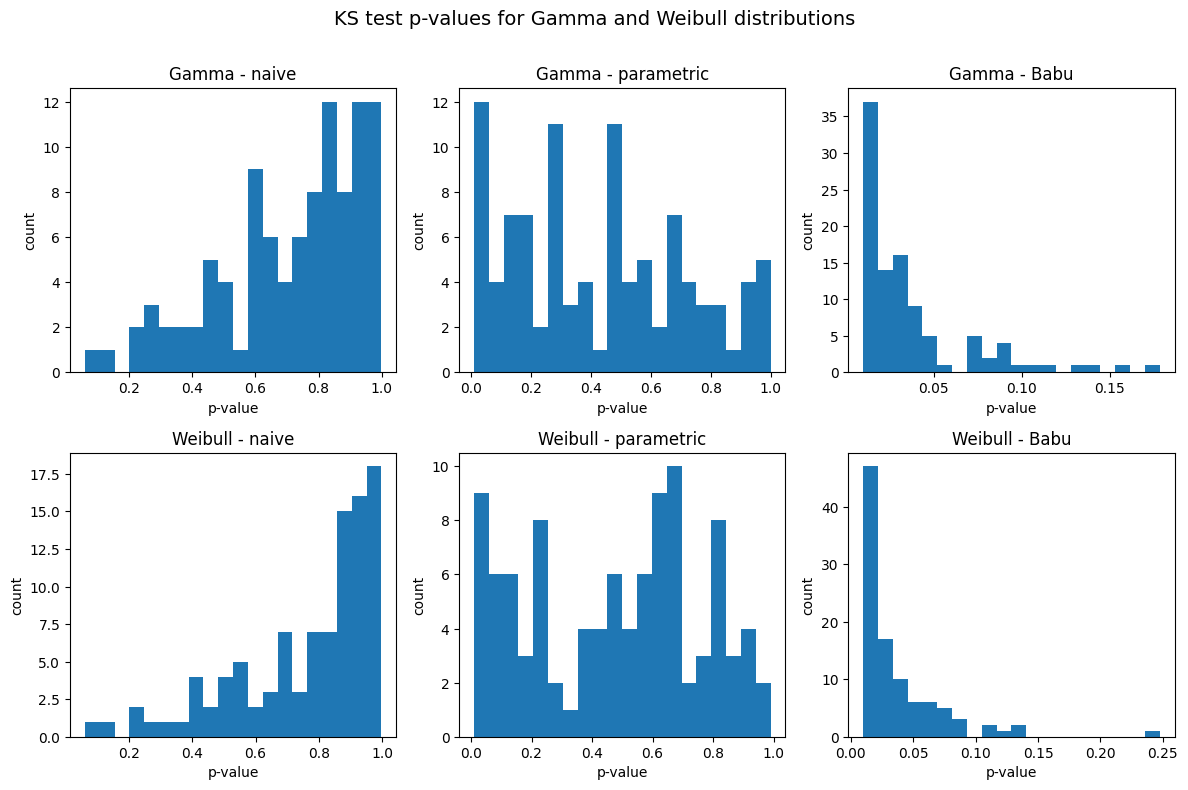

In [53]:
# --- visualise --------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
titles = ['Gamma - naive', 'Gamma - parametric', 'Gamma - Babu',
          'Weibull - naive', 'Weibull - parametric', 'Weibull - Babu']
for ax, data, title in zip(axes,
                           [naive_gamma, para_boot_gamma, nonpara_boot_gamma,
                            naive_weibull, para_boot_weibull, nonpara_boot_weibull],
                           titles):
    ax.hist(data, bins=20)
    ax.set_title(title)
    ax.set_xlabel('p-value')
    ax.set_ylabel('count')
fig.tight_layout(rect=[0, 0, 1, 0.93])
fig.text(0.5, 0.97, 'KS test p-values for Gamma and Weibull distributions',
            ha='center', va='center', fontsize=14)
plt.show()